# Introduction

We decided to go with feature engineering/extraction im combination with shallow classifiers to solve the tasks of SIM1. The tasks we were facing in this exercise where the following:

1. Classify whether Kermit the frog appears in a provided frame of an episode of "The Muppet Show" or not.
2. Classify whether Waldorf & Statler appear in a provided frame of an episode of "The Muppet Show" or not.

Since Kermit the frog has a very intense green colour, we decided to try to go with colour features. More specifically, we will test the suitability of raw pixel values and colour histogram features.

For Waldorf & Statler we are going with a similar idea, but in another domain. Since Waldorf & Statler appear in certain intervals within an episode and are mostly having a short and funny scene where they speak an laugh their voices should distinguish from others quite well. Thus, we will try to extract MFCC features from audio and classify those.

# Project Structure

Directories and Files of the submission are briefly described in the following:

* **SIM1/src/SIM1.ipynb**: The jupyter notebook that holds the solutions for the modelling & classification tasks of Simimarity Modelling 1.
* **SIM1/src/SIM2.ipynb**: The jupyter notebook that holds the solutions for the modelling & classification tasks of Simimarity Modelling 2.
* **SIM1/src/labeler.py**: Small Python program we used to semi-automatically label the videos. This generates labeled images as well as a textfile with the labels per frame for the labeled video.
* **SIM1/src/audio_extractor.py**: Provides utils for extacting audio from videos.
* **SIM1/src/image_extractor.py**: Provides utils for extacting images from videos.
* **SIM1/src/dataset_generator.py**: Provides functionality for extracting the datasets for the specific prediction tasks. Those functionalities are used by the jupyter notebooks.
* **SIM1/src/requiremenets.txt**: The requirements file holding python dependencies which our solution requires
* **ground_truth/audio/mfcc.txt**: Holds the extracted MFCC features which are used for classifying Waldorf & Statler. Features are written to this file when triggered by the corresponding function of **SIM1/src/dataset_generator.py**. The MFCC dataset is sampled randomly from this file.
* **ground_truth/kermit**: This directory contains extracted and labelled images used for training and testing a model used to classify Kermit the frog. Images can be extracted using the corresonding function provided by **SIM1/src/dataset_generator.py**. Moreover, the **labels.txt** file in this directory contains a list of labels represented by episode id, frame number of the image within the episode and the label itself.
* **ground_truth/Muppets-02-01-01/Muppets-02-01-01.txt**: This textfile represents a list of labels for the episode **Muppets-02-01-01.avi**. One line of the file contains frame number of the image and the corresponding label. This file has been generated during labelling the videos using **SIM1/src/labeler.py**.
* **ground_truth/Muppets-02-04-04/Muppets-02-04-04.txt**: This textfile represents a list of labels for the episode **Muppets-02-04-04.avi**. One line of the file contains frame number of the image and the corresponding label. This file has been generated during labelling the videos using **SIM1/src/labeler.py**.
* **ground_truth/Muppets-03-04-03/Muppets-03-04-03.txt**: This textfile represents a list of labels for the episode **Muppets-03-04-03.avi**. One line of the file contains frame number of the image and the corresponding label. This file has been generated during labelling the videos using **SIM1/src/labeler.py**.
* **ground_truth/pig**: This directory contains extracted and labelled images used for training and testing a model used to classify pigs. Images can be extracted using the corresonding function provided by **SIM1/src/dataset_generator.py**. Moreover, the **labels.txt** file in this directory contains a list of labels represented by episode id, frame number of the image within the episode and the label itself.
* **ground_truth/swedish_chef**: This directory contains extracted and labelled images used for training and testing a model used to classify the Swedish Chef. Images can be extracted using the corresonding function provided by **SIM1/src/dataset_generator.py**. Moreover, the **labels.txt** file in this directory contains a list of labels represented by episode id, frame number of the image within the episode and the label itself.
* **audio/**: This directory contains labelled audio data in wav format. The filename represents {episode id}_{label}_{number of audio within episode}. This audio samples have been retrieved using **SIM1/src/dataset_generator.py** with makes use of **SIM1/src/audio_extractor.py** to cut the videos' audios according to screentime of certain characters.
* **videos/**: This directory hold the actual videos in avi format which we need to use for the similarity modelling task. It is important to place them in this ordner since all utility functions expect them to be there.


# Libraries & Definitions used for SIM1

In [1]:
import cv2 # opencv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.feature import hog
from dataset_generator import get_waldorf_statler_mfcc_features, create_kermit_image_dataset

# definitons of constants/variables
video_file_glob_path = '../../videos/*.avi'
audio_base_path = '../../audio/'
kermit_data_path = '../../ground_truth/kermit/'
kermit_label_file = kermit_data_path + 'labels.txt'
evaluation_base_path = '../../evaluation/'

label_map = {0: 'kermit_the_frog',
             1: 'waldorf_and_statler',
             2: 'pig',
             3: 'swedish_chef',
             4: 'none'}

# Helper Functions

In the following, you can see a collection of helper functions used for the modelling task of Kermit the frog. It contains functions to load the image dataset into memory and to extract colour histograms and raw pixel values. Furthermore, we defined a function that splits the overall dataframe into train,test and validation set.

In [2]:
# method for image resizing and extracting vector of raw values
def extract_value_vector(image, size=(128, 128)):
    return cv2.resize(image, size).flatten()

def extract_colour_histogram(image, bins=(32, 32, 32)):
    # convert image to hsv space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # extract color histogram from image and take all 3 channels into account
    color_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    # normalize resulting histogram
    cv2.normalize(color_hist, color_hist)
    
    # return histogram as feature vector
    return color_hist.flatten()

def extract_hog_features(image):
    resized_image = resize(img, (256,128))
    features = hog(resized_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), 
                   visualize=False, multichannel=True)
    return features
    
    

def load_kermit_image_dataset():
    kermit_data = pd.DataFrame([], columns=['name', 'filename', 'kermit'])

    with open(kermit_label_file) as file:
        for i, line in enumerate(file):
            if i == 0:
                continue
            splits = list(map(lambda line: line.strip(), line.split(",")))
            name = splits[0] + '_' + splits[1]
            labels = [int(splits[i]) for i in range(2, len(splits)) if int(splits[i]) != 4]
        
            filename = kermit_data_path + name + '_' + splits[2] + '.jpg'
            kermit_data = kermit_data.append({'name': name,
                                            'file_id': int(splits[0]),
                                            'filename': filename,
                                            'kermit': 1 if 0 in labels else 0}, ignore_index=True)
    return kermit_data


def train_test_validation_split(df):
    video1_df = df[df['file_id'] == 1]
    video2_df = df[df['file_id'] == 2]
    video3_df = df[df['file_id'] == 3]
    
    train_v1_df, test_v1_df, val_v1_df = np.split(video1_df.sample(frac=1, random_state=42), [int(.7*len(video1_df)), int(.9*len(video1_df))])
    train_v2_df, test_v2_df, val_v2_df = np.split(video2_df.sample(frac=1, random_state=42), [int(.7*len(video2_df)), int(.9*len(video2_df))]) 
    train_v3_df, test_v3_df, val_v3_df = np.split(video3_df.sample(frac=1, random_state=42), [int(.7*len(video3_df)), int(.9*len(video3_df))]) 
    
    train_df = pd.concat([train_v1_df, train_v2_df, train_v3_df]).reset_index(drop=True)
    test_df = pd.concat([test_v1_df, test_v2_df, test_v3_df]).reset_index(drop=True)
    val_df = pd.concat([val_v1_df, val_v2_df, val_v3_df]).reset_index(drop=True)
    
    return train_df, test_df, val_df


# Kermit the Frog
## Train/Test/Validation Sets
For this task, we decided to go with the visual domain and extract features from labelled frames which are then used with shallow classifiers. The dataset used for Kermit's similarity modelling task combines images of all 3 videos and consists of 50% positive and 50% negative samples. The positive subset is made up of all images that have been labelled as Kermit in the labelling process. The negative samples are picked randomly from the 3 videos, but with respect of the class distribution over the 3 videos as well as within a video. For example, if Waldorf & Statler appear more oft in the first video, there will be more images of Waldorf & Statler from video 1 than from the other two. The same holds for the distribution of classes within a video. These relations have been calculated based on the size of the 50% positive Kermit samples and the actual number of negative images per class have been sampled randomly. 

The resulting dataset is loaded by our application by calling the corresponding method of **SIM1/src/dataset_generator.py** and then split into 60% traning data and 20% test and validation data each.

## Feature Extraction
Due to Kermit's distinguishable green colour, we decided to go with rather simple colour features and check if we can get good results from those. We decided to go with the following feature extraction approaches:

1. Raw pixel values
2. Colour Histogram
3. Histogram of Oriented Gradient (HOG)

As the first two features clearly focus on colour of pixels, the third one approaches to detect shape features as Kermit's special head and speaking mouth for example. HOG is a technique that counts events of gradient orientation in a specific portion of an image or region of interest and is therefore able to detect certain shaped objects. 
One goal is to obtain if simple colour features perform well or if we need more advanced feature extraction methods as HOG for example.

In [3]:
# create kermit image dataset if not exists (this is checked by the function itself)
create_kermit_image_dataset()

# after dataset creation, load it into dataframe
df_kermit = load_kermit_image_dataset()

Kermit image dataset already created.


In [4]:
## Preprocessing and splitting data for Kermit
df_kermit_cp = df_kermit.copy()

# init data structures for feature vectors, image pixel values and labels
hist_features = []
images_raw_pixels = []
hog_features = []

print('[INFO] start feature extraction')

counter = 1
# iterate over all provided images and extract features, labels and image pixels
for idx, row in df_kermit_cp.iterrows():
    img = cv2.imread(row['filename'])
    # print(row['filename'])
    
    # extract color distribution of the image
    img_color_hist = extract_colour_histogram(img)
    
    # extract raw pixels of the image
    img_pixels = extract_value_vector(img)
    
    # extract HOG features
    hog_feature = extract_hog_features(img)

    hist_features.append(img_color_hist)
    images_raw_pixels.append(img_pixels)
    hog_features.append(hog_feature)
    
    # show process
    if counter % 200 == 0:
        print('[INFO] feature extraction images %d/%d' % (counter, len(df_kermit_cp)))
    counter += 1
    
# add feature lists as new cols to dataframe
df_pre = df_kermit_cp.assign(color_hist = hist_features)
df_pre = df_pre.assign(raw_pixels = images_raw_pixels)
df_kermit_features = df_pre.assign(hog = hog_features)

# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_kermit_features)

# extract specific columns used for classification
x_train_raw = train['raw_pixels'].tolist()
x_train_hist = train['color_hist'].tolist()
x_train_hog = train['hog'].tolist()
y_train = train['kermit'].tolist()

x_test_raw = test['raw_pixels'].tolist()
x_test_hist = test['color_hist'].tolist()
x_test_hog = test['hog'].tolist()
y_test = test['kermit'].tolist()

x_validation_raw = validation['raw_pixels'].tolist()
x_validation_hist = validation['color_hist'].tolist()
x_validation_hog = validation['hog'].tolist()
y_validation = validation['kermit'].tolist()


[INFO] start feature extraction
[INFO] feature extraction images 200/5333
[INFO] feature extraction images 400/5333
[INFO] feature extraction images 600/5333
[INFO] feature extraction images 800/5333
[INFO] feature extraction images 1000/5333
[INFO] feature extraction images 1200/5333
[INFO] feature extraction images 1400/5333
[INFO] feature extraction images 1600/5333
[INFO] feature extraction images 1800/5333
[INFO] feature extraction images 2000/5333
[INFO] feature extraction images 2200/5333
[INFO] feature extraction images 2400/5333
[INFO] feature extraction images 2600/5333
[INFO] feature extraction images 2800/5333
[INFO] feature extraction images 3000/5333
[INFO] feature extraction images 3200/5333
[INFO] feature extraction images 3400/5333
[INFO] feature extraction images 3600/5333
[INFO] feature extraction images 3800/5333
[INFO] feature extraction images 4000/5333
[INFO] feature extraction images 4200/5333
[INFO] feature extraction images 4400/5333
[INFO] feature extraction 

## KNN using Raw Pixel Values


In [5]:
# train a KNN classifier on raw pixel data
model_raw = KNeighborsClassifier(n_neighbors=20)
model_raw.fit(x_train_raw, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

### Confusion Matrix: Test Set

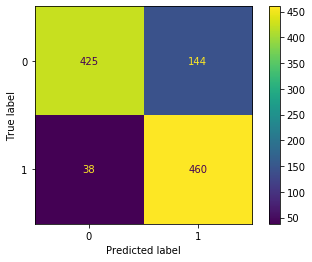

In [7]:
plot_confusion_matrix(model_raw, x_test_raw, y_test, values_format='d')
plt.show()

### ROC Curve: Test Set

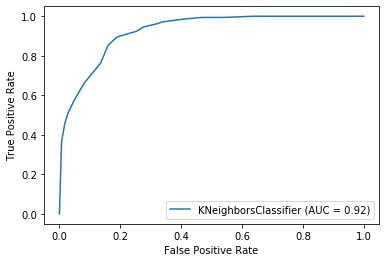

In [8]:
# print text roc curve for KNN classifier trained on raw pixels
plot_roc_curve(model_raw, x_test_raw, y_test)
plt.show()

### ROC Curve: Validation Set

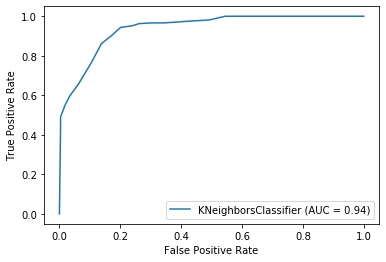

In [9]:
plot_roc_curve(model_raw, x_validation_raw, y_validation)
plt.show()

## KNN using Colour Histogram

In [10]:
# train a KNN classifier on histogram features
model_hist = KNeighborsClassifier(n_neighbors=20, algorithm = 'kd_tree', n_jobs=8)
model_hist.fit(x_train_hist, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=8, n_neighbors=20, p=2,
                     weights='uniform')

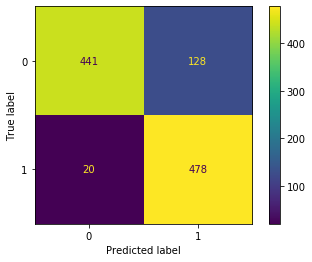

In [11]:
plot_confusion_matrix(model_hist, x_test_hist, y_test, values_format='d')
plt.show()

### ROC Curve: Test Set

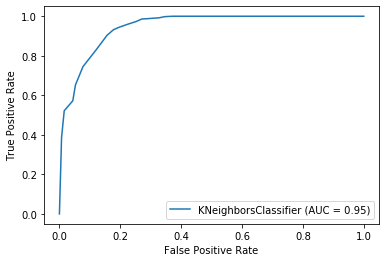

In [12]:
plot_roc_curve(model_hist, x_test_hist, y_test)
plt.show()

### ROC Curve: Validation Set

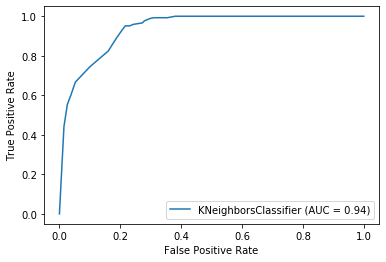

In [13]:
plot_roc_curve(model_hist, x_validation_hist, y_validation)
plt.show()

## SVM using HOG features

In [14]:
# train a SVM on HOG features
svc_parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
model_hog = SVC(kernel='linear')
model_hog = GridSearchCV(model_hog, svc_parameters)
model_hog.fit(x_train_hog, y_train)
print(model_hog.best_params_)

{'C': 1, 'kernel': 'rbf'}


In [15]:
model_hog = SVC(kernel='rbf', C=1)
model_hog.fit(x_train_hog, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

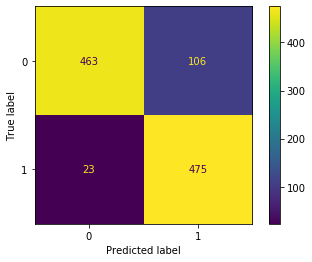

In [16]:
plot_confusion_matrix(model_hog, x_test_hog, y_test, values_format='d')
plt.show()

### ROC Curve: Test Set

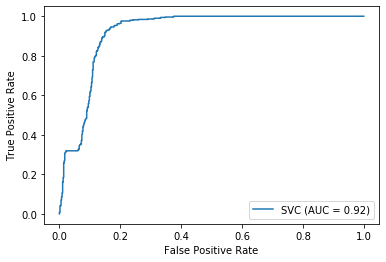

In [17]:
plot_roc_curve(model_hog, x_test_hog, y_test)
plt.show()

### ROC Curve: Validation Set

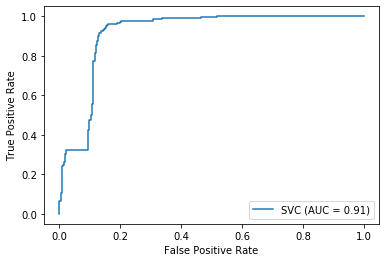

In [18]:
plot_roc_curve(model_hog, x_validation_hog, y_validation)
plt.show()

# Waldorf & Statler

## Train/Test/Validation Sets
To identify if Waldorf & Statler are displayed on a frame, we decided to use feature extraction methods withing the audio domain, because the voices of those elderly gentlemen sound very unique compared to the other characters. Moreover, they often joke and laugh about things.
To obtain an audio dataset from which we extract features and train a shallow classifier on, we used the labelled image data of the 3 videos to be classified. Since we stored the frame number of each labelled sample as well as we know that the framerate of each video is 25 fps, we can calculate the screentimes of each character. This can be done by having a look at blocks of consecutive images having the same class label. The screentime can then be calculated by dividing the frame number of first and last block by the framerate. After having calculated all screentimes per character we used the **pydub** library to actually slice the audios which we have already extracted from videos using **moviepy** library. All this utility is provided by **SIM1/src/audio_extractor.py**.

One challenge was how to actually create a balanced dataset of audios similar to as done for the images. Due to the facts, that for extraction of many audio features overlapping windows are used to capture the fact that audio is a continous signal. To deal with this, we actually decided to implement a utility function which calculates selected features for the previously labelled audio snippets and stores them into a file. Since this stored features are also labelled, we can select all entries that correspond to Waldorf & Statler and randomly sample the other 50% negative samples similarly as done for Kermit. This feature dataset creation utility is provided by **SIM1/src/dataset_generator.py**.
After importing this data, it is again split into train, test and validation data (70-20-10).

## Feature Extraction
For the feature extraction task regarding Waldorf & Statler, we decided to go with MFCC features and evaluate if the obtainable results can be considered as suitable. 
Mel Frequency Cepstral Coefficients (MFCC) takes human perception for sensitivity at appropriate frequencies into account by converting the conventional frequency to Mel Scale. Therefore, it should be quite suitable for our speech/audio recognition task. 
We decided to go with 20 MFCC coefficients. Moreover, we chose the length of an audio frame to be 20ms with 50% overlapping. For calculation of the MFCC features, we decided to the **librosa** library, because it is used most often in this context. The described dataset creation and feature extraction utilities are provided by **SIM1/src/dataset_generator.py**.

In [19]:
## Identifying Waldorf/Statler
# loading the already preprocessed MFCC feature dataset into dataframe
frame_length_ms = 20
n_mfcc_coeffs = 20
ws_raw_data = get_waldorf_statler_mfcc_features(frame_length_ms, n_mfcc_coeffs)
df_ws =  pd.DataFrame(ws_raw_data, columns=['label', 'file_id', 'mfcc'])

Read MFCC features for random sampling...
Number of samples for target class 1: 9428
Create data distribution map...
Successfully extracted MFCC feature dataset for character: 1


In [20]:
# split dataframe into train, test and validation set
train, test, validation = train_test_validation_split(df_ws)

# extract specific columns used for classification
x_train_mfcc = train['mfcc'].tolist()
y_train_mfcc = train['label'].tolist()

x_test_mfcc = test['mfcc'].tolist()
y_test_mfcc = test['label'].tolist()

x_validation_mfcc = validation['mfcc'].tolist()
y_validation_mfcc = validation['label'].tolist()

In [21]:
# train a random forest classifier on mfcc features
ws_rf_cls = RandomForestClassifier(n_estimators=200)
ws_rf_cls.fit(x_train_mfcc, y_train_mfcc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

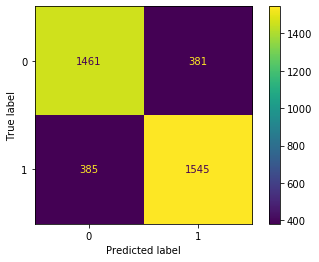

In [22]:
plot_confusion_matrix(ws_rf_cls, x_test_mfcc, y_test_mfcc, values_format='d')
plt.show()

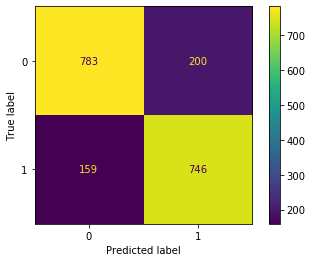

In [23]:
plot_confusion_matrix(ws_rf_cls, x_validation_mfcc, y_validation_mfcc, values_format='d')
plt.show()

### ROC Curve: Test Set

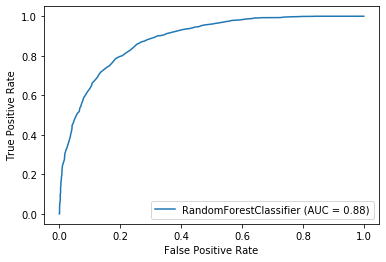

In [24]:
plot_roc_curve(ws_rf_cls, x_test_mfcc, y_test_mfcc)
plt.show()

### ROC Curve: Validation Set

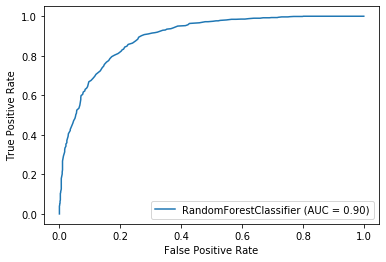

In [25]:
plot_roc_curve(ws_rf_cls, x_validation_mfcc, y_validation_mfcc)
plt.show()

# Conclusion

TBD...